# Lab 4 - Part 2: Document Classification, Sentiment Analysis & Topic Modeling

**Course:** Natural Language Processing

**Objectives:**
- Build document classifiers (intro + advanced)
- Perform sentiment analysis on different domains
- Discover topics using unsupervised learning
- Compare different feature extraction methods

---

## Instructions

1. Complete all exercises marked with `# YOUR CODE HERE`
2. **Answer all written questions** in the designated markdown cells
3. Save your completed notebook
4. **Push to your Git repository and send the link to: yoroba93@gmail.com**

### Personal Analysis Required

This lab contains questions requiring YOUR personal interpretation.

---

## Use Cases Covered

| Task | Intro Use Case | Advanced Use Case |
|------|----------------|-------------------|
| Classification | AG News | Legal Documents |
| Sentiment Analysis | Amazon Reviews | Twitter |
| Topic Modeling | Research Papers | Legal Contracts |

---

## Setup

In [139]:
# Install required libraries (uncomment if needed)
# !pip install datasets scikit-learn nltk pandas numpy matplotlib seaborn wordcloud gensim

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# NLTK
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix the LookupError
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.pipeline import Pipeline

# Hugging Face datasets
from datasets import load_dataset

print("Setup complete!")

Setup complete!


In [141]:
# Common preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_simple(text):
    """Basic preprocessing: lowercase, remove punctuation."""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join(text.split())

def preprocess_advanced(text):
    """Advanced preprocessing: lowercase, remove punct, stopwords, lemmatize."""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

print("Preprocessing functions ready!")

Preprocessing functions ready!


---

# PART A: Document Classification

We will work with two use cases:
1. **Intro:** News Topic Classification (AG News)
2. **Advanced:** Legal Document Classification (LexGLUE)

## A.1 Intro: News Topic Classification (AG News)

**Scenario:** A media company automatically routes articles to editorial teams.

**Feature Extraction:** TF-IDF

In [142]:
# Load AG News dataset
print("Loading AG News dataset...")
ag_news = load_dataset("ag_news")

# Use subset for faster processing
ag_train = pd.DataFrame(ag_news['train']).sample(n=8000, random_state=42)
ag_test = pd.DataFrame(ag_news['test']).sample(n=2000, random_state=42)

# Label mapping
ag_labels = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
ag_train['label_name'] = ag_train['label'].map(ag_labels)
ag_test['label_name'] = ag_test['label'].map(ag_labels)

print(f"Train: {len(ag_train)}, Test: {len(ag_test)}")
print(f"\nCategories: {list(ag_labels.values())}")
print(ag_train['label_name'].value_counts())

Loading AG News dataset...
Train: 8000, Test: 2000

Categories: ['World', 'Sports', 'Business', 'Sci/Tech']
label_name
Sports      2074
Sci/Tech    2021
Business    1959
World       1946
Name: count, dtype: int64


In [143]:
# Preprocess
ag_train['text_clean'] = ag_train['text'].apply(preprocess_simple)
ag_test['text_clean'] = ag_test['text'].apply(preprocess_simple)

# TF-IDF Vectorization
tfidf_ag = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_ag = tfidf_ag.fit_transform(ag_train['text_clean'])
X_test_ag = tfidf_ag.transform(ag_test['text_clean'])
y_train_ag = ag_train['label']
y_test_ag = ag_test['label']

print(f"TF-IDF features: {X_train_ag.shape[1]}")

TF-IDF features: 5000


### Exercise A.1: Train a News Classifier

In [144]:
# TODO: Train a Logistic Regression classifier on AG News
# 1. Create the classifier
# 2. Train it
# 3. Make predictions
# 4. Calculate accuracy and F1-score (macro)

# YOUR CODE HERE
clf_ag = LogisticRegression(max_iter=1000, random_state=42)  # Create LogisticRegression

# Train
clf_ag.fit(X_train_ag, y_train_ag)
# Predict
y_pred_ag = clf_ag.predict(X_test_ag)

# Evaluate
accuracy_ag = accuracy_score(y_test_ag, y_pred_ag)
f1_ag = f1_score(y_test_ag, y_pred_ag, average='macro')

print(f"AG News Classification Results:")
print(f"  Accuracy: {accuracy_ag:.4f}")
print(f"  F1 (macro): {f1_ag:.4f}")

AG News Classification Results:
  Accuracy: 0.8810
  F1 (macro): 0.8803


In [145]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_ag, y_pred_ag, target_names=list(ag_labels.values())))


Classification Report:
              precision    recall  f1-score   support

       World       0.89      0.88      0.89       493
      Sports       0.94      0.96      0.95       504
    Business       0.84      0.82      0.83       474
    Sci/Tech       0.85      0.86      0.86       529

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



## A.2 Advanced: Legal Document Classification (LexGLUE - ECtHR)

**Scenario:** A law firm classifies court decisions by violated articles.

**Feature Extraction:** Bag of Words with N-grams

**Challenge:** Legal text is longer and uses specialized vocabulary.

In [146]:
# Load LexGLUE ECtHR dataset (European Court of Human Rights)
print("Loading LexGLUE ECtHR dataset...")
lex_glue = load_dataset("lex_glue", "ecthr_a")

# Convert to DataFrame
lex_train = pd.DataFrame(lex_glue['train'])
lex_test = pd.DataFrame(lex_glue['test'])

# Use subset (legal docs are long)
lex_train = lex_train.sample(n=min(1500, len(lex_train)), random_state=42)
lex_test = lex_test.sample(n=min(500, len(lex_test)), random_state=42)

print(f"Train: {len(lex_train)}, Test: {len(lex_test)}")
print(f"\nColumns: {lex_train.columns.tolist()}")

Loading LexGLUE ECtHR dataset...
Train: 1500, Test: 500

Columns: ['text', 'labels']


In [147]:
# Examine the data structure
print("Sample legal document (first 500 chars):")
sample_text = ' '.join(lex_train.iloc[0]['text'][:3])  # text is a list of paragraphs
print(sample_text[:500])

print(f"\nLabels (violated articles): {lex_train.iloc[0]['labels']}")

Sample legal document (first 500 chars):
5.  The applicant, Mr Laszlo Kilyen, was born in 1972 and lives in Murgeşti. 6.  On 10 May 2003 police officers T.M. and L.C.V. were carrying out an investigation into the theft of two cars in the village of Murgeşti. The applicant, who lived alone in a house with a yard, was away from home on a trip abroad. On the same day at around 4 p.m., the two officers entered the applicant’s yard by breaking the main gate which had a closing system made by the applicant from metal wires. The officers took

Labels (violated articles): [4]


In [148]:
# Prepare data: combine text paragraphs and use first label for simplicity
def prepare_legal_text(row):
    """Join text paragraphs and truncate."""
    full_text = ' '.join(row['text'])
    return full_text[:5000]  # Truncate long documents

lex_train['full_text'] = lex_train.apply(prepare_legal_text, axis=1)
lex_test['full_text'] = lex_test.apply(prepare_legal_text, axis=1)

# Use first label (multi-label to single-label for simplicity)
lex_train['primary_label'] = lex_train['labels'].apply(lambda x: x[0] if x else -1)
lex_test['primary_label'] = lex_test['labels'].apply(lambda x: x[0] if x else -1)

# Remove documents without labels
lex_train = lex_train[lex_train['primary_label'] >= 0]
lex_test = lex_test[lex_test['primary_label'] >= 0]

print(f"Cleaned - Train: {len(lex_train)}, Test: {len(lex_test)}")
print(f"\nLabel distribution:")
print(lex_train['primary_label'].value_counts().head(10))

Cleaned - Train: 1340, Test: 428

Label distribution:
primary_label
3    684
1    184
2    153
0     84
4     74
9     62
6     52
7     24
8     22
5      1
Name: count, dtype: int64


### Exercise A.2: Build a Legal Document Classifier

In [149]:
# TODO: Complete the legal document classifier using Bag of Words

# Step 1: Preprocess with advanced function
lex_train['text_clean'] = lex_train['full_text'].apply(preprocess_advanced)
lex_test['text_clean'] = lex_test['full_text'].apply(preprocess_advanced)

# Step 2: Create CountVectorizer (Bag of Words) with bigrams
# YOUR CODE HERE
bow_legal = CountVectorizer(
    max_features=4000,      # Choose: 3000-5000
    ngram_range=(1,2),       # Choose: (1,1), (1,2), or (1,3)
    min_df=3,            # Choose: 2-5
    max_df=0.95             # Choose: 0.9-0.99
)

# Step 3: Transform data
X_train_lex = bow_legal.fit_transform(lex_train['text_clean'])
X_test_lex = bow_legal.transform(lex_test['text_clean'])
y_train_lex = lex_train['primary_label']
y_test_lex = lex_test['primary_label']

print(f"BoW features: {X_train_lex.shape[1]}")

BoW features: 4000


In [150]:
# TODO: Train a Linear SVM classifier (good for high-dimensional legal text) or other model

# YOUR CODE HERE
clf_legal = LinearSVC(random_state=42, max_iter=2000)  # Create LinearSVC

# Train
clf_legal.fit(X_train_lex, y_train_lex)

# Predict
y_pred_lex = clf_legal.predict(X_test_lex)

# Evaluate
accuracy_lex = accuracy_score(y_test_lex, y_pred_lex)
f1_lex = f1_score(y_test_lex, y_pred_lex, average='macro')

print(f"Legal Classification Results:")
print(f"  Accuracy: {accuracy_lex:.4f}")
print(f"  F1 (macro): {f1_lex:.4f}")

Legal Classification Results:
  Accuracy: 0.6332
  F1 (macro): 0.4884


### Written Question A.1 (Personal Interpretation)

Compare your results from AG News and Legal classification:

1. **Which task achieved higher accuracy?** Why do you think there's a difference?
2. **What vectorizer parameters did you choose for legal text?** Justify each choice.
3. **What challenges are unique to legal document classification?** (Consider: length, vocabulary, ambiguity)

**YOUR ANSWER:**

1. Accuracy comparison:
   - AG News: 0.8810 | Legal: 0.6332
   - Reason for difference: AG News is easier. News articles use simple language and have clear topics. Legal documents have complex vocabulary, long sentences, and technical terms.

2. My vectorizer choices:
   - max_features=4000 because because legal text has many special words
   - ngram_range=（1,2） because legal phrases (like "human rights") are important
   - min_df=3 because remove rare words
   - max_df=0.95 because keep common legal terms

3. Legal classification challenges:
   - Length: Very long documents
   - Vocabulary: Special legal words
   - Ambiguity: Same words can mean different things in law
   - Multi-label: Many documents have multiple labels

---

# PART B: Sentiment Analysis

We will work with two use cases:
1. **Intro:** E-commerce Product Reviews (Amazon)
2. **Advanced:** Social Media Sentiment (Twitter/TweetEval)

## B.1 Intro: Amazon Product Reviews

**Scenario:** An e-commerce company monitors product sentiment.

**Feature Extraction:** TF-IDF

In [151]:
# Load Amazon Reviews dataset (multilingual, we'll use English)
print("Loading Amazon Reviews dataset...")
amazon = load_dataset("SetFit/amazon_reviews_multi_en")

# Convert to DataFrame and sample
amazon_train = pd.DataFrame(amazon['train']).sample(n=5000, random_state=42)
amazon_test = pd.DataFrame(amazon['test']).sample(n=1000, random_state=42)

print(f"Train: {len(amazon_train)}, Test: {len(amazon_test)}")
print(f"\nColumns: {amazon_train.columns.tolist()}")
print(f"\nStar rating distribution:")
print(amazon_train['label'].value_counts().sort_index())

Loading Amazon Reviews dataset...
Train: 5000, Test: 1000

Columns: ['id', 'text', 'label', 'label_text']

Star rating distribution:
label
0    1007
1     982
2    1003
3     987
4    1021
Name: count, dtype: int64


In [152]:
# Convert to binary sentiment (1-2 stars = negative, 4-5 stars = positive)
# Remove neutral (3 stars) for clearer distinction

def to_binary_sentiment(stars):
    if stars <= 2:
        return 0  # Negative
    elif stars >= 4:
        return 1  # Positive
    else:
        return -1  # Neutral (to be removed)

amazon_train['sentiment'] = amazon_train['label'].apply(to_binary_sentiment) # Changed 'star_rating' to 'label'
amazon_test['sentiment'] = amazon_test['label'].apply(to_binary_sentiment)   # Changed 'star_rating' to 'label'

# Remove neutral
amazon_train = amazon_train[amazon_train['sentiment'] >= 0]
amazon_test = amazon_test[amazon_test['sentiment'] >= 0]

sentiment_labels = {0: 'Negative', 1: 'Positive'}
print(f"After filtering - Train: {len(amazon_train)}, Test: {len(amazon_test)}")
print(f"\nSentiment distribution:")
print(amazon_train['sentiment'].value_counts())

After filtering - Train: 4013, Test: 790

Sentiment distribution:
sentiment
0    2992
1    1021
Name: count, dtype: int64


In [153]:
# Show sample reviews
print("Sample POSITIVE review:")
pos_sample = amazon_train[amazon_train['sentiment'] == 1].iloc[0]
print(f"Product: {pos_sample['label_text']}") # Changed from 'product_category' to 'label_text'
print(f"Review: {pos_sample['text'][:300]}...") # Changed from 'review_body' to 'text'

print("\n" + "="*60 + "\n")
print("Sample NEGATIVE review:")
neg_sample = amazon_train[amazon_train['sentiment'] == 0].iloc[0]
print(f"Product: {neg_sample['label_text']}") # Changed from 'product_category' to 'label_text'
print(f"Review: {neg_sample['text'][:300]}...") # Changed from 'review_body' to 'text'

Sample POSITIVE review:
Product: 4
Review: These bags have a lot of space in them, good thing about these bags is that I can easily see what's inside then. Very reasonable price....


Sample NEGATIVE review:
Product: 2
Review: Not strong enough to run a small 120v vacuum cleaner, to clean car....


### Exercise B.1: Build Amazon Sentiment Classifier

In [154]:
# TODO: Build sentiment classifier for Amazon reviews

# Step 1: Preprocess
amazon_train['text_clean'] = amazon_train['text'].apply(preprocess_simple) # Changed 'review_body' to 'text'
amazon_test['text_clean'] = amazon_test['text'].apply(preprocess_simple)   # Changed 'review_body' to 'text'

# Step 2: TF-IDF
tfidf_amazon = TfidfVectorizer(max_features=5000, stop_words='english') # Filled in

X_train_amz = tfidf_amazon.fit_transform(amazon_train['text_clean'])
X_test_amz = tfidf_amazon.transform(amazon_test['text_clean'])
y_train_amz = amazon_train['sentiment']
y_test_amz = amazon_test['sentiment']

# Step 3 & 4: YOUR CODE HERE - Train Naive Bayes and evaluate or choose another model if not suitable
clf_amazon = MultinomialNB()  # Create MultinomialNB

# Train
clf_amazon.fit(X_train_amz, y_train_amz)

# Predict
y_pred_amz = clf_amazon.predict(X_test_amz)

# Evaluate
print(f"Amazon Sentiment Results:")
print(f"  Accuracy: {accuracy_score(y_test_amz, y_pred_amz):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_amz, y_pred_amz, target_names=['Negative', 'Positive']))

Amazon Sentiment Results:
  Accuracy: 0.8089

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      1.00      0.89       598
    Positive       0.98      0.22      0.36       192

    accuracy                           0.81       790
   macro avg       0.89      0.61      0.62       790
weighted avg       0.84      0.81      0.76       790



In [155]:
# Analyze most predictive words
feature_names = tfidf_amazon.get_feature_names_out()

# For Naive Bayes, use log probabilities
neg_probs = clf_amazon.feature_log_prob_[0]
pos_probs = clf_amazon.feature_log_prob_[1]
log_ratio = pos_probs - neg_probs

# Top positive and negative words
top_pos_idx = log_ratio.argsort()[-15:]
top_neg_idx = log_ratio.argsort()[:15]

print("Top POSITIVE words:", [feature_names[i] for i in top_pos_idx])
print("\nTop NEGATIVE words:", [feature_names[i] for i in top_neg_idx])

Top POSITIVE words: ['swallow', 'wonderful', 'genius', 'blanket', 'massage', 'love', 'projector', 'moms', 'perfect', 'charm', 'lightweight', 'excellent', 'exactly', 'amazing', 'loves']

Top NEGATIVE words: ['broke', 'broken', 'return', 'waste', 'returned', 'cheap', 'disappointed', 'poor', 'ok', 'stopped', 'didnt', 'returning', 'started', 'open', 'received']


## B.2 Advanced: Twitter Sentiment (TweetEval)

**Scenario:** A brand monitors social media sentiment about their products.

**Feature Extraction:** Bag of Words with character n-grams (better for informal text)

**Challenge:** Tweets are short, informal, with hashtags, mentions, and slang.

In [156]:
# Load TweetEval sentiment dataset
print("Loading TweetEval Sentiment dataset...")
tweet_eval = load_dataset("tweet_eval", "sentiment")

tweet_train = pd.DataFrame(tweet_eval['train'])
tweet_test = pd.DataFrame(tweet_eval['test'])

# Labels: 0=negative, 1=neutral, 2=positive
tweet_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
tweet_train['label_name'] = tweet_train['label'].map(tweet_labels)
tweet_test['label_name'] = tweet_test['label'].map(tweet_labels)

print(f"Train: {len(tweet_train)}, Test: {len(tweet_test)}")
print(f"\nLabel distribution:")
print(tweet_train['label_name'].value_counts())

Loading TweetEval Sentiment dataset...
Train: 45615, Test: 12284

Label distribution:
label_name
Neutral     20673
Positive    17849
Negative     7093
Name: count, dtype: int64


In [157]:
# Sample tweets
for label in [0, 1, 2]:
    sample = tweet_train[tweet_train['label'] == label].iloc[0]
    print(f"[{tweet_labels[label]}]: {sample['text']}\n")

[Negative]: So disappointed in wwe summerslam! I want to see john cena wins his 16th title

[Neutral]: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"

[Positive]: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"



In [158]:
# Special preprocessing for tweets
def preprocess_tweet(text):
    """Preprocess tweet text."""
    text = str(text).lower()
    # Keep @mentions and #hashtags but simplify
    text = re.sub(r'@\w+', '@user', text)  # Replace mentions with @user
    text = re.sub(r'http\S+', 'URL', text)  # Replace URLs
    text = re.sub(r'[^a-zA-Z@#\s]', '', text)  # Keep @ and # symbols
    return ' '.join(text.split())

tweet_train['text_clean'] = tweet_train['text'].apply(preprocess_tweet)
tweet_test['text_clean'] = tweet_test['text'].apply(preprocess_tweet)

print("Sample preprocessed tweet:")
print(f"Original: {tweet_train.iloc[0]['text']}")
print(f"Cleaned:  {tweet_train.iloc[0]['text_clean']}")

Sample preprocessed tweet:
Original: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
Cleaned:  qt @user in the original draft of the th book remus lupin survived the battle of hogwarts #happybirthdayremuslupin


### Exercise B.2: Build Twitter Sentiment Classifier

In [159]:
# TODO: Build a classifier using character n-grams (good for short, informal text)

# YOUR CODE HERE: Create a vectorizer with character n-grams
# Hint: Use analyzer='char_wb' for word-boundary-aware character n-grams

char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',           # 'char_wb' for character n-grams with word boundaries
    ngram_range=(2,5),        # Try (2,5) or (3,6) for character n-grams
    max_features=4000,       # 3000-5000
    min_df=3              # 2-5
)

X_train_tw = char_vectorizer.fit_transform(tweet_train['text_clean'])
X_test_tw = char_vectorizer.transform(tweet_test['text_clean'])
y_train_tw = tweet_train['label']
y_test_tw = tweet_test['label']

print(f"Character n-gram features: {X_train_tw.shape[1]}")

Character n-gram features: 4000


In [160]:
# TODO: Train Logistic Regression and evaluate

clf_tweet = LogisticRegression(max_iter=1000, random_state=42)  # YOUR CODE HERE

# Train and predict
clf_tweet.fit(X_train_tw, y_train_tw)
y_pred_tw = clf_tweet.predict(X_test_tw)

# Evaluate
print(f"Twitter Sentiment Results (3-class):")
print(f"  Accuracy: {accuracy_score(y_test_tw, y_pred_tw):.4f}")
print(f"  F1 (macro): {f1_score(y_test_tw, y_pred_tw, average='macro'):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_tw, y_pred_tw, target_names=list(tweet_labels.values())))

Twitter Sentiment Results (3-class):
  Accuracy: 0.5794
  F1 (macro): 0.5474

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.34      0.45      3972
     Neutral       0.59      0.74      0.65      5937
    Positive       0.49      0.59      0.54      2375

    accuracy                           0.58     12284
   macro avg       0.59      0.56      0.55     12284
weighted avg       0.60      0.58      0.57     12284



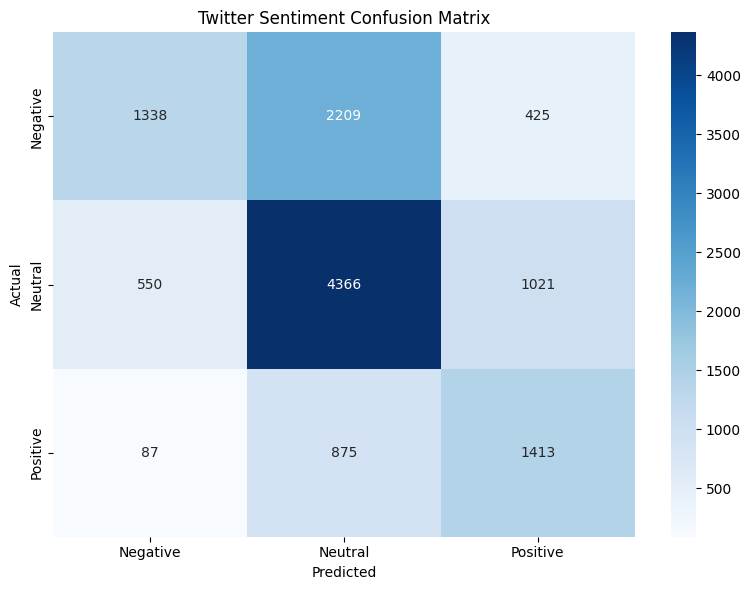

In [161]:
# Confusion matrix
cm_tw = confusion_matrix(y_test_tw, y_pred_tw)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tw, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(tweet_labels.values()),
            yticklabels=list(tweet_labels.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Twitter Sentiment Confusion Matrix')
plt.tight_layout()
plt.savefig('twitter_sentiment_cm.png', dpi=150)
plt.show()

### Written Question B.1 (Personal Interpretation)

Compare Amazon vs Twitter sentiment analysis:

1. **Which task was harder?** Look at the F1 scores and confusion matrices.
2. **Why did you choose those character n-gram parameters for Twitter?** What's the advantage over word n-grams?
3. **Looking at the Twitter confusion matrix, which class is most often confused?** Why might this be?
4. **Give an example tweet that would be hard to classify correctly.** Explain why.

**YOUR ANSWER:**

1. Harder task:
   - Amazon F1: 0.62 | Twitter F1: 0.5474
   - Reason: Twitter is harder. It has 3 classes. Tweets are short and informal.

2. Character n-gram choices:
   - ngram_range=（2,5） because  it catches emoticons and hashtags
   - Advantage over words: Better for slang and short messages
3. Most confused class:
   - Class: Negative
   - Reason: Negative tweets have low recall. They are often predicted as Neutral.

4. Difficult tweet example:
   - Tweet: It's okay, not great but not bad
   - Why it's hard: It has mixed feelings. Hard to decide between Neutral and Positive.

---

# PART C: Topic Modeling

We will work with two use cases:
1. **Intro:** Research Paper Topics (ArXiv)
2. **Advanced:** Legal Contract Topics

## C.1 Intro: Research Paper Topic Discovery (ArXiv)

**Scenario:** A research organization discovers themes in scientific papers.

**Method:** LDA (Latent Dirichlet Allocation)

In [162]:
# Load ArXiv papers dataset
print("Loading ArXiv papers dataset (this may take a moment)...")
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("RimshaAIWizard/armanc_scientific_papers_arxiv_dataset")
# Sample from training set
arxiv_df = pd.DataFrame(ds['train']).sample(n=2000, random_state=42)

print(f"Loaded {len(arxiv_df)} papers")
print(f"Columns: {arxiv_df.columns.tolist()}")

Loading ArXiv papers dataset (this may take a moment)...
Loaded 2000 papers
Columns: ['article', 'abstract', 'section_names']


In [163]:
# Examine sample
print("Sample paper abstract (first 500 chars):")
print(arxiv_df.iloc[0]['abstract'][:500])

Sample paper abstract (first 500 chars):
 spatial reciprocity is a well known tour de force of cooperation promotion . 
 a thorough understanding of the effects of different population densities is therefore crucial . here 
 we study the evolution of cooperation in social dilemmas on different interaction graphs with a certain fraction of vacant nodes . 
 we find that sparsity may favor the resolution of social dilemmas , especially if the population density is close to the percolation threshold of the underlying graph . 
 regardless o


In [164]:
# Preprocess abstracts for topic modeling
arxiv_df['abstract_clean'] = arxiv_df['abstract'].apply(preprocess_advanced)

# Create document-term matrix with CountVectorizer
count_vec_arxiv = CountVectorizer(max_features=5000, stop_words='english')

dtm_arxiv = count_vec_arxiv.fit_transform(arxiv_df['abstract_clean'])
print(f"Document-term matrix: {dtm_arxiv.shape}")

Document-term matrix: (2000, 5000)


In [165]:
# Train LDA model
n_topics_arxiv = 10  # Scientific papers likely have diverse topics. Choose appropriately (8-12).

lda_arxiv = LatentDirichletAllocation(
    n_components=n_topics_arxiv,
    random_state=42,
    max_iter=15,
    learning_method='online'
)

print("Training LDA on ArXiv papers...")
lda_arxiv.fit(dtm_arxiv)
print("Done!")

Training LDA on ArXiv papers...
Done!


In [166]:
# Display topics
def display_lda_topics(model, feature_names, n_words=12):
    """Display top words for each LDA topic."""
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

feature_names_arxiv = count_vec_arxiv.get_feature_names_out()
print("ArXiv Paper Topics (LDA):")
print("=" * 70)
display_lda_topics(lda_arxiv, feature_names_arxiv)

ArXiv Paper Topics (LDA):
Topic 0: particle, flow, simulation, model, velocity, non, tube, dynamic, field, magnetic, motion, energy
Topic 1: galaxy, xmath, star, mass, cluster, model, disk, stellar, formation, gas, result, black
Topic 2: model, method, algorithm, problem, solution, time, network, equation, result, paper, function, theory
Topic 3: mass, neutrino, energy, model, physic, quark, xmath, production, data, decay, collision, particle
Topic 4: xmath, xcite, value, function, distribution, fig, number, energy, case, result, time, given
Topic 5: ray, emission, source, spectrum, xmath, observation, radio, flux, energy, high, line, region
Topic 6: force, field, wave, string, frequency, electric, spp, vacuum, dielectric, spider, medium, elastic
Topic 7: xmath, state, field, energy, model, spin, phase, order, theory, interaction, temperature, transition
Topic 8: structure, frequency, time, observed, change, temperature, layer, high, optical, rate, model, behavior
Topic 9: quantum, sta

### Exercise C.1: Interpret ArXiv Topics

In [167]:
# TODO: Assign meaningful labels to each topic based on the keywords

my_arxiv_topic_labels = {
    0: "Fluid Dynamics/Particle Physics", # YOUR LABEL
    1: "Astrophysics",  # YOUR LABEL
    2: "Computer Science & Algorithms", # YOUR LABEL
    3: "High Energy Physics", # YOUR LABEL
    4: "Mathematics & Statistics", # YOUR LABEL
    5: "Astronomy & Observations", # YOUR LABEL
    6: "Electromagnetics & Waves", # YOUR LABEL
    7: "Condensed Matter Physics", # YOUR LABEL
    8: "Materials Science", # YOUR LABEL
    9: "Quantum Physics" # YOUR LABEL
}

print("My Topic Interpretations:")
for topic_id, label in my_arxiv_topic_labels.items():
    if label != "___":
        print(f"  Topic {topic_id}: {label}")

My Topic Interpretations:
  Topic 0: Fluid Dynamics/Particle Physics
  Topic 1: Astrophysics
  Topic 2: Computer Science & Algorithms
  Topic 3: High Energy Physics
  Topic 4: Mathematics & Statistics
  Topic 5: Astronomy & Observations
  Topic 6: Electromagnetics & Waves
  Topic 7: Condensed Matter Physics
  Topic 8: Materials Science
  Topic 9: Quantum Physics


## C.2 Advanced: Legal Contract Topic Discovery

**Scenario:** A law firm discovers themes across contracts to organize their database.

**Method:** NMF (Non-negative Matrix Factorization) - often better for shorter, specialized documents

**Challenge:** Legal language is formal and domain-specific.

In [168]:
# Load legal contracts dataset (streaming to handle large size)
print("Loading Legal Contracts dataset...")
from datasets import load_dataset

ds = load_dataset("hugsid/legal-contracts")
# Take first 1500 contracts
legal_contracts = []
for i, item in enumerate(ds['train']): # Corrected to use ds['train']
    if i >= 1500:
        break
    legal_contracts.append(item)

legal_df = pd.DataFrame(legal_contracts)
print(f"Loaded {len(legal_df)} contracts")

Loading Legal Contracts dataset...
Loaded 1500 contracts


In [169]:
# Preprocess legal text (truncate long documents)
legal_df['text_truncated'] = legal_df['text'].str[:8000]  # Truncate
legal_df['text_clean'] = legal_df['text_truncated'].apply(preprocess_advanced)

print("Sample contract (cleaned, first 300 chars):")
print(legal_df.iloc[0]['text_clean'][:300])

Sample contract (cleaned, first 300 chars):
supplement joinder agreement agreement dated september made among triangle capital corporation maryland corporation borrower guarantor party credit agreement referred branch banking trust company administrative agent swingline lender existing lender pursuant credit agreement administrative agent uni


### Exercise C.2: Build NMF Topic Model for Legal Contracts

In [170]:
# TODO: Create TF-IDF vectorizer for NMF (NMF works better with TF-IDF)

tfidf_legal = TfidfVectorizer(max_features=3000, stop_words='english')

dtm_legal = tfidf_legal.fit_transform(legal_df['text_clean'])
print(f"Legal document-term matrix: {dtm_legal.shape}")

Legal document-term matrix: (1500, 3000)


In [171]:
# TODO: Train NMF model
# Choose number of topics (legal contracts may have: employment, confidentiality, IP, services, etc.)

n_topics_legal = 8  # YOUR CHOICE: 5-12

nmf_legal = NMF(
    n_components=n_topics_legal,
    random_state=42,
    max_iter=200
)

print(f"Training NMF with {n_topics_legal} topics...")
nmf_legal.fit(dtm_legal)
print("Done!")

Training NMF with 8 topics...
Done!


In [172]:
# Display NMF topics
def display_nmf_topics(model, feature_names, n_words=12):
    """Display top words for each NMF topic."""
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

feature_names_legal = tfidf_legal.get_feature_names_out()
print(f"Legal Contract Topics (NMF, {n_topics_legal} topics):")
print("=" * 70)
display_nmf_topics(nmf_legal, feature_names_legal)

Legal Contract Topics (NMF, 8 topics):
Topic 0: agent, administrative, lender, shall, borrower, payment, time, notice, account, tax, request, applicable
Topic 1: subsidiary, person, company, indebtedness, consolidated, asset, property, business, financial, insurance, equity, restricted
Topic 2: rate, day, eurodollar, loan, base, period, eurocurrency, advance, annum, borrowing, applicable, shall
Topic 3: lender, swing, line, defaulting, loan, assignment, obligation, commitment, shall, section, participation, hereunder
Topic 4: plan, erisa, code, section, pension, multiemployer, affiliate, expected, contribution, employer, title, borrower
Topic 5: date, representation, warranty, correct, true, commitment, earlier, default, material, effect, borrowing, shall
Topic 6: party, agreement, document, loan, obligation, action, transaction, law, right, collateral, hereto, proceeding
Topic 7: credit, letter, issuer, bank, issuing, time, agreement, revolving, term, drawing, issued, outstanding


In [173]:
# TODO: Assign labels to legal topics

my_legal_topic_labels = {}  # Add your labels: {0: "label", 1: "label", ...}

# YOUR CODE HERE - fill the dictionary
legal_labels = [
    "Loan Administration & Payments",
    "Corporate Finance & Assets",
    "Interest Rates & Loan Terms",
    "Loan Default & Assignments",
    "Pension & Retirement Plans",
    "Contract Warranties & Representations",
    "Legal Proceedings & Agreements",
    "Letters of Credit & Banking"
]

for i in range(n_topics_legal):
    my_legal_topic_labels[i] = legal_labels[i]

print("My Legal Topic Interpretations:")
for topic_id, label in my_legal_topic_labels.items():
    if label != "___":
        print(f"  Topic {topic_id}: {label}")

My Legal Topic Interpretations:
  Topic 0: Loan Administration & Payments
  Topic 1: Corporate Finance & Assets
  Topic 2: Interest Rates & Loan Terms
  Topic 3: Loan Default & Assignments
  Topic 4: Pension & Retirement Plans
  Topic 5: Contract Warranties & Representations
  Topic 6: Legal Proceedings & Agreements
  Topic 7: Letters of Credit & Banking


### Exercise C.3: Topic Distribution Visualization

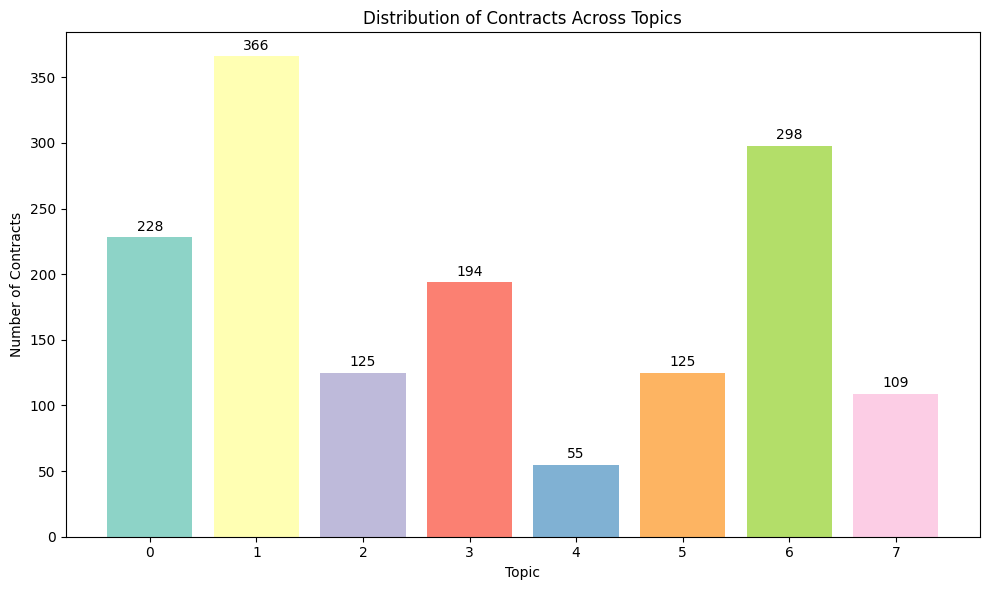

In [174]:
# Get document-topic distributions
doc_topics_legal = nmf_legal.transform(dtm_legal)

# Assign dominant topic
legal_df['dominant_topic'] = doc_topics_legal.argmax(axis=1)

# Visualize topic distribution
plt.figure(figsize=(10, 6))
topic_counts = legal_df['dominant_topic'].value_counts().sort_index()
bars = plt.bar(topic_counts.index, topic_counts.values, color=plt.cm.Set3(range(len(topic_counts))))
plt.xlabel('Topic')
plt.ylabel('Number of Contracts')
plt.title('Distribution of Contracts Across Topics')
plt.xticks(range(n_topics_legal))

# Add count labels
for bar, count in zip(bars, topic_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('legal_topic_distribution.png', dpi=150)
plt.show()

### Written Question C.1 (Personal Interpretation)

Compare ArXiv (LDA) vs Legal Contracts (NMF) topic modeling:

1. **Which set of topics was easier to interpret?** Why?
2. **Looking at the legal topic distribution, is it balanced?** What does this tell you about the contract dataset?
3. **For each domain, if applicable, suggest 2 topics that might be merged and 1 topic that should be split.** Justify.

**YOUR ANSWER:**

1. Easier to interpret:
   - Domain: ArXiv papers
   - Reason: Scientific topics have clear keywords (like "particle" for physics, "quantum" for quantum physics)

2. Legal topic distribution:
   - Balanced? No, some topics have many contracts, others have few
   - What this indicates: The dataset contains more loan/credit contracts than other types

3. Topic refinement suggestions:
   - ArXiv - Merge: Topics 1 (Astrophysics) and 5 (Astronomy) because both study stars and galaxies
   - ArXiv - Split: Topic 2 (Computer Science) because it's too broad (includes algorithms, networks, etc.)
   - Legal - Merge: Topics 0 and 2 because both about loans and credit
   - Legal - Split: Topic 6 because it covers many different legal actions

---

## Summary - Lab 4 Part 2

### Methods Summary

| Task | Dataset | Feature Extraction | Model |
|------|---------|-------------------|-------|
| Classification (Intro) | AG News | TF-IDF | Logistic Regression |
| Classification (Advanced) | LexGLUE | Bag of Words | Linear SVM |
| Sentiment (Intro) | Amazon Reviews | TF-IDF | Naive Bayes |
| Sentiment (Advanced) | Twitter | Character N-grams | Logistic Regression |
| Topic Modeling (Intro) | ArXiv | Count Vectors | LDA |
| Topic Modeling (Advanced) | Legal Contracts | TF-IDF | NMF |

### Key Takeaways

- **Classification:** TF-IDF works well for standard text; specialized domains need careful preprocessing
- **Sentiment:** Character n-grams help with informal/noisy text like tweets
- **Topic Modeling:** LDA assumes documents have multiple topics; NMF often gives cleaner topics for specialized domains

---

## Submission Checklist

- [ ] All code exercises completed (fill all `___` placeholders)
- [ ] **All written questions answered with YOUR personal interpretation**
- [ ] All visualizations saved (PNG files)
- [ ] Notebook saved
- [ ] Pushed to Git repository
- [ ] **Repository link sent to: yoroba93@gmail.com**
